# 1- Diffusion problem with zero boundary conditions


We want to solve:
$$
\begin{align*}
    -\Delta u &= f(x,y)\\
    u(x,y) &=0 \quad \forall x  \forall y  \in \partial \Omega
\end{align*}
$$
We set u = $(1-x^2)(1-y^2)$ the exact solution in order to find f(x,y)
$$
\begin{align*}
    u(x, y) &= (1-x^2)(1-y^2) \\
    &= 1 -y^2 -x^2(1-y^2) \\
\end{align*}
\\
\begin{align*}
    \frac{\partial u}{\partial x}(x, y) = -2x(1-y^2) \\
\end{align*}
\\
\begin{align*}
    \frac{\partial^2u}{\partial x^2}(x,y) = -2(1-y^2)
\end{align*}
$$
So, we want to solve the following problem:
$$
\begin{align*}
    -\Delta u &= 2(1-y^2) + 2(1-x^2)\\
    u(x,y) &=0 \quad \forall x  \forall y  \in \partial \Omega
\end{align*}
$$
We are going to minimise:
$$
\begin{align*}
    L = \frac{1}{2}\int_\Omega |\nabla u(x,y)|^2dx dy - \int_\Omega f(x,y)u(x,y)dx dy + \beta \frac{1}{N_{boundary}}\sum_{i=0}^{N_{boundary}}(u(x_i, y_i) - \hat{u}(x_i, y_i))^2
\end{align*}
$$
The advantage of this manufactured example is that we can compute exactly each term of the loss and know if we approximate it correctly:
$$
\begin{align*}
    \frac{1}{2}\int_\Omega |\nabla u(x,y)|^2dx dy &= \frac{1}{2}\int_{-1}^{1}\int_{-1}^{1}4x^2(1-y^2)^2dxdy \\
    &= \frac{128}{45}
\end{align*}
$$
$$
\begin{align*}
    \int_\Omega f(x,y)u(x,y)dx dy &= \frac{1}{2}\int_{-1}^{1}\int_{-1}^{1}(2(1-y^2)+2(1-x^2))(1-x^2)(1-y^2)dxdy \\
    &= \frac{256}{45}
\end{align*}
$$

In [1]:
# import dolfin
import sys, os
import torch
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from NeuralNetworks import fwdNN as fwd
from NeuralNetworks import residualNN as rnn
from NeuralNetworks import convNN as cnn
import plots
from fenics import *

Invalid MIT-MAGIC-COOKIE-1 key

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/lucas/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
def generate_circle_points(center_point, radius, N, tol, restrict_to_domain=False):
    r = radius * torch.sqrt(torch.rand(N).to(center_point.device))
    theta = 2 * torch.pi * torch.rand(N).to(center_point.device)

    x = center_point[0] + r * torch.cos(theta)
    y = center_point[1] + r * torch.sin(theta)

    if restrict_to_domain:
        x, y = torch.clamp(x, -1+tol, 1-tol), torch.clamp(y, -1+tol, 1-tol)

    return torch.stack((x, y), dim=1)

def circle_procreation(points, radius, N, tol=1e-3):
    new_points = torch.tensor([]).to(points.device)
    for center_points in points:
        to_add = generate_circle_points(center_points, radius, N, tol, restrict_to_domain=True)
        new_points = torch.cat((new_points, to_add), dim=0)
    return new_points

def compute_mean_center_vs_neighboor(centers, neighboors, N):
    mean = torch.zeros(centers.shape[0], centers.shape[1]).to(centers.device)
    for i in range(centers.shape[0]):
        center_i = centers[i, :]
        neighboors_i = neighboors[i*N:(i+1)*N, :]
        mean_i = torch.cat((neighboors_i, center_i.unsqueeze(0)), dim=0).mean(dim=0)
        mean_i = mean_i.unsqueeze(0)
        mean[i, :] = mean_i
    return mean

In [4]:
class DeepRitzLoss(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

    def forward(self, x_omega, ux_omega, fx, ux_boundary, cl_boundary, reg_boundary=500):
        grad_u = torch.autograd.grad(inputs=x_omega, outputs=ux_omega, grad_outputs=torch.ones_like(ux_omega), create_graph=True)[0]
        grad_ux1, grad_ux2 = grad_u[:, 0], grad_u[:, 1]
        
        physical_term1 = grad_ux1.pow(2) + grad_ux2.pow(2)
        physical_term2 = fx*ux_omega
        boundary_term = (cl_boundary - ux_boundary).pow(2)

        loss_term1 = 4/2*physical_term1.mean()
        loss_term2 = 4*physical_term2.mean()
        loss_term3 = boundary_term.mean()
        loss = loss_term1 - loss_term2 + reg_boundary*loss_term3

        return loss, loss_term1, loss_term2, loss_term3
    
class DeepRitzCircledLoss(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

    def forward(self, x_omega, x_omega_circle, ux_omega, ux_omega_circle, fx, ux_boundary, cl_boundary, reg_boundary=500, N_circle=10):
        grad_u = torch.autograd.grad(inputs=x_omega, outputs=ux_omega, grad_outputs=torch.ones_like(ux_omega), create_graph=True)[0]
        grad_u_circle = torch.autograd.grad(inputs=x_omega_circle, outputs=ux_omega_circle, grad_outputs=torch.ones_like(ux_omega_circle), create_graph=True)[0]
        
        grad_u_approx = compute_mean_center_vs_neighboor(grad_u, grad_u_circle, N_circle)
        
        grad_ux1, grad_ux2 = grad_u_approx[:, 0], grad_u_approx[:, 1]

        physical_term1 = grad_ux1.pow(2) + grad_ux2.pow(2)
        physical_term2 = fx*ux_omega
        boundary_term = (cl_boundary - ux_boundary).pow(2)

        loss_term1 = 4/2*physical_term1.mean()
        loss_term2 = 4*physical_term2.mean()
        loss_term3 = boundary_term.mean()
        loss = loss_term1 - loss_term2 + reg_boundary*loss_term3

        return loss, loss_term1, loss_term2, loss_term3

In [5]:
class Omega2D_config1(Dataset):
    def __init__(self, n_omega=100, n_boundary=75, x_bounds=[-1, 1], y_bounds=[-1, 1]):

        self.n_omega = n_omega
        self.n_boundary = n_boundary
        self.x_bounds = x_bounds
        self.y_bounds = y_bounds

        self.omega_train, self.boundary_train, self.integration_points = self._create_points_for_training()

    def _create_points_for_training(self):
        xmin, xmax = self.x_bounds
        ymin, ymax = self.y_bounds

        x = np.random.uniform(xmin, xmax, self.n_omega)
        y = np.random.uniform(ymin, ymax, self.n_omega)
        omega_coordinates = np.column_stack((x, y))

        n_per_boundary = self.n_boundary//4
        x_left, y_left = xmin*np.ones(n_per_boundary), np.random.uniform(ymin, ymax, n_per_boundary)
        x_right, y_right = xmax*np.ones(n_per_boundary), np.random.uniform(ymin, ymax, n_per_boundary)
        x_bottom, y_bottom = np.random.uniform(xmin, xmax, n_per_boundary), ymin*np.ones(n_per_boundary)
        x_top, y_top = np.random.uniform(xmin, xmax, n_per_boundary), ymax*np.ones(n_per_boundary)
        x_boundary = np.concatenate((x_left, x_right, x_bottom, x_top))
        y_boundary = np.concatenate((y_left, y_right, y_bottom, y_top))
        boundary_coordinates = np.column_stack((x_boundary, y_boundary))

        integration_points = np.concatenate((omega_coordinates, boundary_coordinates))

        return omega_coordinates, boundary_coordinates, integration_points

class Omega2D_config2(Dataset):
    def __init__(self, grid_size=9, x_bounds=[-1, 1], y_bounds=[-1, 1]):

        self.grid_size = grid_size
        self.x_bounds = x_bounds
        self.y_bounds = y_bounds

        self.omega_train, self.boundary_train, self.integration_points = self._create_points_for_training()

    def _create_points_for_training(self):

        N = self.grid_size
        x_bounds = self.x_bounds
        y_bounds = self.y_bounds

        mesh = RectangleMesh(Point(x_bounds[0], y_bounds[0]), Point(x_bounds[1], y_bounds[1]), N, N)

        class Boundary(SubDomain):
            def inside(self, x, on_boundary):
                return (near(x[0], -1) or near(x[0], 1) or near(x[1], -1) or near(x[1], 1))

        boundary_markers = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
        boundary_markers.set_all(0)
        boundary = Boundary()

        boundary_coordinates = set()
        omega_coordinates = set()

        for vertex in vertices(mesh):
            x = vertex.point().array()  
            if boundary.inside(x, True):
                boundary_coordinates.add((x[0], x[1]))
            else:
                omega_coordinates.add((x[0], x[1]))

        boundary_coordinates = np.array(list(boundary_coordinates))
        omega_coordinates = np.array(list(omega_coordinates))

        integration_points = np.concatenate((omega_coordinates, boundary_coordinates))
        return omega_coordinates, boundary_coordinates, integration_points

In [6]:
def order_for_kernel(X, kernel_size, grid_size):
    k = kernel_size
    gr = grid_size+1

    indices = np.lexsort((X[:, 0], X[:, 1])) # sort by y and then by x
    X_sorted = X[indices]

    n_slide = gr - k + 1

    final_x = np.empty((0, 2))


    for i in range(n_slide):
        slide_x = X_sorted[i:k+i]
        final_x = np.concatenate((final_x, slide_x), axis=0)
        for j in range(k):
            final_x = np.concatenate((final_x, X_sorted[gr*j+i].reshape(1, 2)), axis=0)
    return final_x

def order_by_columns(X):
    return X[np.lexsort((X[:, 1], X[:, 0]))]

def order_by_rows(X):
    return X[np.lexsort((X[:, 0], X[:, 1]))]

In [7]:
class Circle():
    def __init__(self, hidden_size=20, nn='res', config=1, init_grid=9):
        
        if nn == 'fwd':
            n_hidden_layers = int(input('Number of hidden layers: '))
            self.model = fwd.FullyConnectedNetwork(input_dim=2, n_hidden_layers=n_hidden_layers, hidden_size=hidden_size).to(device)
            self.sig = 'fwd'
        elif nn == 'res':
            self.model = rnn.RitzModel(input_dim=2, num_blocks=4, hidden_size=hidden_size).to(device)
            self.sig = 'res'
        else:
            self.model = cnn.ConvolutionalNetwork(input_dim=2, hidden_size=hidden_size).to(device)
            self.sig = 'cnn'
        
        if config == 1 or config == 2:
            self.criterion = DeepRitzLoss()
        else:
            self.criterion = DeepRitzCircledLoss()

        self.integration_grid = self._init_grid(init_grid)
        self.total_loss = []
        self.physical_loss1 = []
        self.physical_loss2 = []
        self.boundary_loss = []

        self.model_name = f'{nn}_fc{hidden_size}_'

        if config == 1:
            self.config = 1
            self.train = self.train_config1
        elif config == 2:
            self.config = 2
            self.train = self.train_config2
        else:
            self.config = 3
            self.train = self.train_config3

    def _init_grid(self, init_grid=9):
        return Omega2D_config2(init_grid).integration_points
    
    def train_config1(self, n_iter, n_omega, n_boundary, beta):

        criterion = self.criterion
        model_optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0005)
        self.model.train()

        model_name = f'iter{n_iter//1000}k_nw{n_omega}_ndw{n_boundary}_beta{beta}.pth'
        self.model_name += model_name
        
        for iter_i in range(n_iter):
            integration_grid = Omega2D_config1(n_omega=n_omega, n_boundary=n_boundary)

            x_omega = torch.FloatTensor(integration_grid.omega_train).to(device)
            x_boundary = torch.FloatTensor(integration_grid.boundary_train).to(device)
            fx_omega = (torch.FloatTensor(self.f(x_omega.cpu())).unsqueeze(1)).to(device)
            cl_boundary = self.cl_boundary(x_boundary).to(device)
            x_omega.requires_grad = True

            model_optimizer.zero_grad()
            ux_omega = self.model(x_omega)
            ux_boundary = self.model(x_boundary)
            loss, physical_loss1, physical_loss2, boundary_loss = criterion(x_omega, ux_omega, fx_omega, ux_boundary, cl_boundary, beta)

            self.total_loss.append(loss.item())
            self.physical_loss1.append(physical_loss1.item())
            self.physical_loss2.append(physical_loss2.item())
            self.boundary_loss.append(boundary_loss.item())

            loss.backward()
            model_optimizer.step()

            if iter_i % 100 == 0:
                print(f'Iteration {iter_i}, loss: {loss.item()}')

        self.integration_grid = integration_grid.integration_points

    def train_config2(self, n_iter, beta, grid_size=9, regularization=0):
        """
            Integration points generated only once using a uniform grid with fewer points
        """

        model_name = f'iter{n_iter//1000}k_beta{beta}_gr{grid_size+1}'
        self.model_name += model_name
        criterion = self.criterion
        model_optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0005, weight_decay=regularization) # lr = 0.0005 / weight_decay = 0.125
        # scheduler = torch.optim.lr_scheduler.ExponentialLR(model_optimizer, gamma=0.95)

        integration_grid = Omega2D_config2(grid_size)
        x_omega = torch.FloatTensor(integration_grid.omega_train).to(device)
        # x_omega = torch.FloatTensor(order_for_kernel(integration_grid.omega_train, 3, grid_size)).to(device)
        # x_omega = torch.FloatTensor(order_by_columns(integration_grid.omega_train)).to(device)
        x_boundary = torch.FloatTensor(integration_grid.boundary_train).to(device)
        fx_omega = (torch.FloatTensor(self.f(x_omega.cpu())).unsqueeze(1)).to(device)
        cl_boundary = self.cl_boundary(x_boundary).to(device)
        x_omega.requires_grad = True
        
        self.model.train()

        for iter_i in range(n_iter):
            model_optimizer.zero_grad()

            indices = torch.randperm(x_omega.size(0))  
            x_omega = x_omega[indices].detach().requires_grad_()
            fx_omega = fx_omega[indices]
            
            ux_omega = self.model(x_omega)
            ux_boundary = self.model(x_boundary)
            loss, physical_loss1, physical_loss2, boundary_loss = criterion(x_omega, ux_omega, fx_omega, ux_boundary, cl_boundary, beta)

            self.total_loss.append(loss.item())
            self.physical_loss1.append(physical_loss1.item())
            self.physical_loss2.append(physical_loss2.item())
            self.boundary_loss.append(boundary_loss.item())

            loss.backward()
            model_optimizer.step()
            # scheduler.step(loss)
            
            if iter_i % 100 == 0:
                print(f'Iteration {iter_i}, loss: {loss.item()}')

        self.integration_grid = integration_grid.integration_points

    def train_config3(self, n_iter, beta, grid_size=9, N_circle=10, radius=0.1):
        model_name = f'iter{n_iter//1000}k_beta{beta}_gr{grid_size+1}_k{N_circle}'
        self.model_name = model_name
        criterion = self.criterion
        model_optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0005)
        integration_grid = Omega2D_config2(grid_size)

        x_omega = torch.FloatTensor(integration_grid.omega_train).to(device)
        x_omega_circle = circle_procreation(x_omega, radius, N_circle, True).to(device)

        x_boundary = torch.FloatTensor(integration_grid.boundary_train).to(device)
        x_boundary_circle = circle_procreation(x_boundary, radius, N_circle, False).to(device)
        
        fx_omega = (torch.FloatTensor(self.f(x_omega.cpu())).unsqueeze(1)).to(device)
        cl_boundary = self.cl_boundary(x_boundary).to(device)
        cl_boundary_circle = self.cl_boundary(x_boundary_circle).to(device)

        cl_boundary = compute_mean_center_vs_neighboor(cl_boundary, cl_boundary_circle, N_circle)

        x_omega.requires_grad = True
        x_omega_circle.requires_grad = True
        self.model.train()

        for iter_i in range(n_iter):
            model_optimizer.zero_grad()
            ux_omega = self.model(x_omega)
            ux_omega_circle = self.model(x_omega_circle)
            ux_boundary = self.model(x_boundary)
            loss, physical_loss1, physical_loss2, boundary_loss = criterion(x_omega, x_omega_circle, ux_omega, ux_omega_circle, fx_omega, ux_boundary, cl_boundary, beta, N_circle)

            self.total_loss.append(loss.item())
            self.physical_loss1.append(physical_loss1.item())
            self.physical_loss2.append(physical_loss2.item())
            self.boundary_loss.append(boundary_loss.item())

            loss.backward()
            model_optimizer.step()

            if iter_i % 100 == 0:
                print(f'Iteration {iter_i}, loss: {loss.item()}')

        self.integration_grid = integration_grid.integration_points

    def cl_boundary(self, x):
        return torch.zeros(x.shape[0], 1)
    
    def f(self, x):
        x1, x2 = x[:, 0], x[:, 1]
        fx = 2*(1-x2**2) + 2*(1-x1**2)
        return fx
    
    def u(self, x):
        x1, x2 = x[:, 0], x[:, 1]
        u = (1-x1**2)*(1-x2**2)
        return u
    
    def du_x1_exact(self, x):
        x1, x2 = x[:, 0], x[:, 1]
        du_x1 = -2*x1*(1-x2**2)
        return du_x1
    
    def du_x2_exact(self, x):
        x1, x2 = x[:, 0], x[:, 1]
        du_x2 = -2*x2*(1-x1**2)
        return du_x2
    
    def plot_loss(self, save=False):

        fig1 = plt.figure()
        plt.plot(self.physical_loss1, label=r'$\nabla_x u \cdot \nabla_x u$', color='blue')
        plt.plot(np.ones(len(self.physical_loss1))*128/45, label=r'Analytical solution of $\nabla_x u \cdot \nabla_x u$', color='#00008B')
        plt.plot(self.physical_loss2, label=r'fu', color='orange')
        plt.plot(np.ones(len(self.physical_loss2))*256/45, label=r'Analytical solution of $fu$', color='red')
        plt.legend()
        plt.xlabel('Iterations')

        fig2, ax = plt.subplots(1, 2, figsize=(15, 5))
        ax[0].plot(self.boundary_loss, label=r'$(u - c_l)^2$', color='black')
        ax[0].legend()
        ax[0].set_xlabel('Iterations')
        ax[0].set_yscale('log')

        ax[1].plot(np.array(self.total_loss) - 64/45 + 256/45, label='Total loss', color='black')
        ax[1].legend()
        ax[1].set_xlabel('Iterations')
        ax[1].set_yscale('log')

        plt.tight_layout()

        if save:
            if not os.path.exists((f'./Figures/ex1_config{self.config}/{self.model_name}')):
                os.makedirs(f'./Figures/ex1_config{self.config}/{self.model_name}')

            torch.save(self.model.state_dict(), f'./Models/ex1_config{self.config}/{self.model_name}.pth')
            fig1.savefig(f'./Figures/ex1_config{self.config}/{self.model_name}/terms.png')
            fig2.savefig(f'./Figures/ex1_config{self.config}/{self.model_name}/bc&total.png')

    def plot_metrics(self, evaluation_grid_size, save=False, show_points=True):
        mesh_coordinates = (RectangleMesh(Point(-1, -1), Point(1, 1), evaluation_grid_size, evaluation_grid_size)).coordinates()
        evaluation_domain_points = torch.FloatTensor(mesh_coordinates).to(device)
        evaluation_domain_points.requires_grad = True

        model = self.model
        model.eval()

        u_pred = model(evaluation_domain_points)
        u_exact = (self.u(evaluation_domain_points.cpu()).unsqueeze(1)).to(device)
        u_pred_reshaped = plots.reshape_tensor_to_cpu(u_pred, evaluation_grid_size)
        u_exact_reshaped = plots.reshape_tensor_to_cpu(u_exact, evaluation_grid_size)

        du_pred_x1, du_pred_x2 = plots.partial_derivative_2D(u=u_pred,x=evaluation_domain_points)
        du_exact_x1, du_exact_x2 = self.du_x1_exact(evaluation_domain_points), self.du_x2_exact(evaluation_domain_points) 
        du_pred_x1_reshaped, du_pred_x2_reshaped = plots.reshape_tensor_to_cpu(du_pred_x1, evaluation_grid_size), plots.reshape_tensor_to_cpu(du_pred_x2, evaluation_grid_size)
        du_exact_x1_reshaped, du_exact_x2_reshaped = plots.reshape_tensor_to_cpu(du_exact_x1, evaluation_grid_size), plots.reshape_tensor_to_cpu(du_exact_x2, evaluation_grid_size)

        mae = plots.compute_mae(plots.to_cpu(u_pred), plots.to_cpu(u_exact))
        err_relative_l2 = plots.compute_l2_relative_error(u_pred, u_exact)
        err_relative_h1 = plots.compute_h1_relative_error(u_pred, u_exact, evaluation_domain_points)

        if show_points:
            fig0 = plots.plot_config1(u_pred_reshaped, u_exact_reshaped, 'U', self.integration_grid)
            fig1 = plots.plot_config1(du_pred_x1_reshaped, du_exact_x1_reshaped, 'du/dx1', self.integration_grid)
            fig2 = plots.plot_config1(du_pred_x2_reshaped, du_exact_x2_reshaped, 'du/dx2', self.integration_grid)
        else:
            fig0 = plots.plot_config1(u_pred_reshaped, u_exact_reshaped, 'U')
            fig1 = plots.plot_config1(du_pred_x1_reshaped, du_exact_x1_reshaped, 'du/dx1')
            fig2 = plots.plot_config1(du_pred_x2_reshaped, du_exact_x2_reshaped, 'du/dx2')

        if save:
            fig0.savefig(f'./Figures/ex1_config{self.config}/{self.model_name}/U_gr{evaluation_grid_size+1}')
            fig1.savefig(f'./Figures/ex1_config{self.config}/{self.model_name}/dU_dx1_gr{evaluation_grid_size+1}')
            fig2.savefig(f'./Figures/ex1_config{self.config}/{self.model_name}/dU_dx2_gr{evaluation_grid_size+1}')

    def plot_metrics3d(self, evaluation_grid_size, save=False):
        mesh_coordinates = (RectangleMesh(Point(-1, -1), Point(1, 1), evaluation_grid_size, evaluation_grid_size)).coordinates()
        evaluation_domain_points = torch.FloatTensor(mesh_coordinates).to(device)
        evaluation_domain_points.requires_grad = True

        model = self.model
        model.eval()

        X = mesh_coordinates[:, 0].reshape(evaluation_grid_size+1, evaluation_grid_size+1)
        Y = mesh_coordinates[:, 1].reshape(evaluation_grid_size+1, evaluation_grid_size+1)

        u_pred = model(evaluation_domain_points)
        u_exact = (self.u(evaluation_domain_points.cpu()).unsqueeze(1)).to(device)
        u_pred_reshaped = plots.reshape_tensor_to_cpu(u_pred, evaluation_grid_size)
        u_exact_reshaped = plots.reshape_tensor_to_cpu(u_exact, evaluation_grid_size)

        du_pred_x1, du_pred_x2 = plots.partial_derivative_2D(u=u_pred,x=evaluation_domain_points)
        du_exact_x1, du_exact_x2 = self.du_x1_exact(evaluation_domain_points), self.du_x2_exact(evaluation_domain_points) 
        du_pred_x1_reshaped, du_pred_x2_reshaped = plots.reshape_tensor_to_cpu(du_pred_x1, evaluation_grid_size), plots.reshape_tensor_to_cpu(du_pred_x2, evaluation_grid_size)
        du_exact_x1_reshaped, du_exact_x2_reshaped = plots.reshape_tensor_to_cpu(du_exact_x1, evaluation_grid_size), plots.reshape_tensor_to_cpu(du_exact_x2, evaluation_grid_size)

        fig = plots.plot_config2(X, Y, u_exact_reshaped, u_pred_reshaped,
                                 du_exact_x1_reshaped, du_pred_x1_reshaped, du_exact_x2_reshaped, du_pred_x2_reshaped)
        

In [8]:
torch.manual_seed(15)

In [9]:
integration_choice = {1:'MC Grid', 2:'Uniform Grid', 3:'Gradient Averaging'}
model_choice = {'hidden size':20, 'NN':'fwd', 'Configuration choice':2}

gr = 19
reg = 1.1/(gr+1) + 0.015
print(f'Applied regularization: {reg}')

training_configurations = {
    1: {'n_iter': 10000, 'n_omega': 1000, 'n_boundary': 250, 'beta': 500},
    2: {'n_iter': 25000, 'beta': 3000, 'grid_size': gr, 'regularization': reg},
    3: {'n_iter': 8000, 'beta': 1000, 'grid_size': 9, 'N_circle': 20, 'radius': 0.2}
}
selected_config = training_configurations[model_choice['Configuration choice']]

fig_path = f'ex1_config{model_choice["Configuration choice"]}'
model = Circle(hidden_size=model_choice['hidden size'], nn=model_choice['NN'], config=model_choice['Configuration choice'])
model.train(**selected_config)

Applied regularization: 0.07
Iteration 0, loss: 15.164098739624023
Iteration 100, loss: 0.000378522090613842
Iteration 200, loss: -0.0014130137860774994
Iteration 300, loss: -0.003349294885993004
Iteration 400, loss: -0.005344103090465069
Iteration 500, loss: -0.007280630990862846
Iteration 600, loss: -0.009098480455577374
Iteration 700, loss: -0.010775025002658367
Iteration 800, loss: -0.01231230329722166
Iteration 900, loss: -0.013726877048611641
Iteration 1000, loss: -0.01504240557551384
Iteration 1100, loss: -0.016284873709082603
Iteration 1200, loss: -0.017479468137025833
Iteration 1300, loss: -0.018649175763130188
Iteration 1400, loss: -0.01981402561068535
Iteration 1500, loss: -0.020991414785385132
Iteration 1600, loss: -0.02219628356397152
Iteration 1700, loss: -0.023442022502422333
Iteration 1800, loss: -0.02474077418446541
Iteration 1900, loss: -0.02610403299331665
Iteration 2000, loss: -0.027542762458324432
Iteration 2100, loss: -0.029067358002066612
Iteration 2200, loss: -0

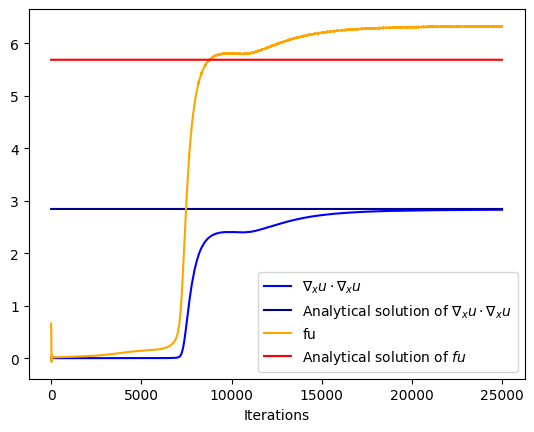

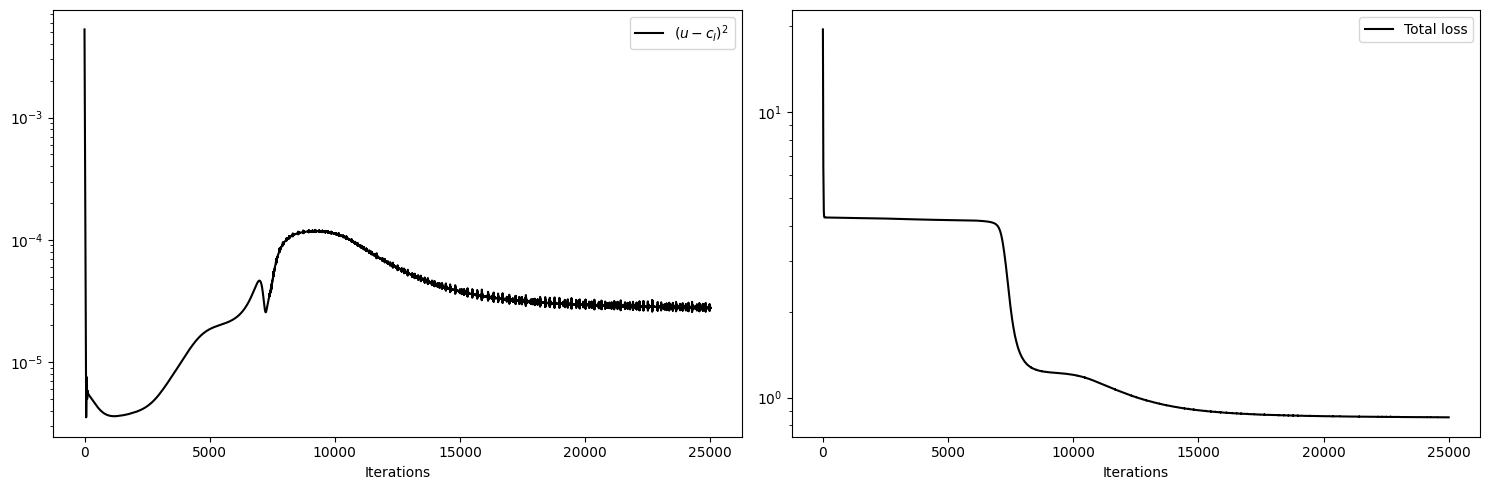

In [10]:
model.plot_loss(save=False)

Gradient computation: dim ok
Mean absolute error: 0.020408766344189644
l2_relative_error: 0.04751495450570741, l2_u_true: 26.133325576782227, l2_u_pred: 26.461254119873047
h1_relative_error: 0.11041809371808382, h1_u_true: 65.64767456054688, h1_u_pred: 65.43075561523438


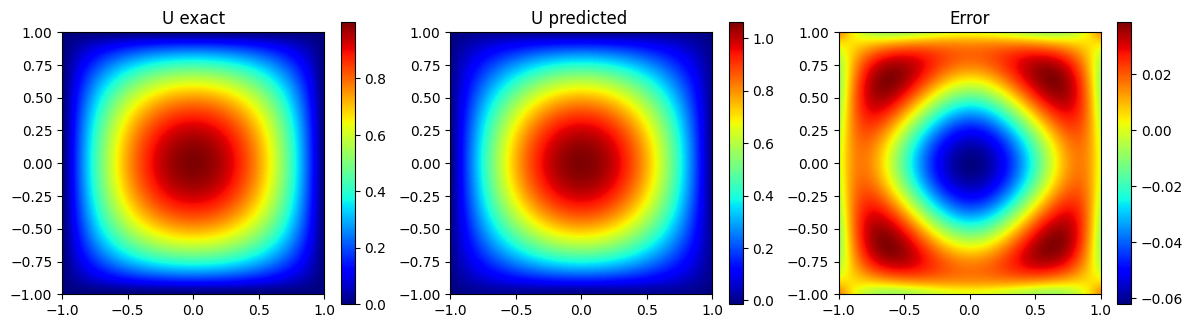

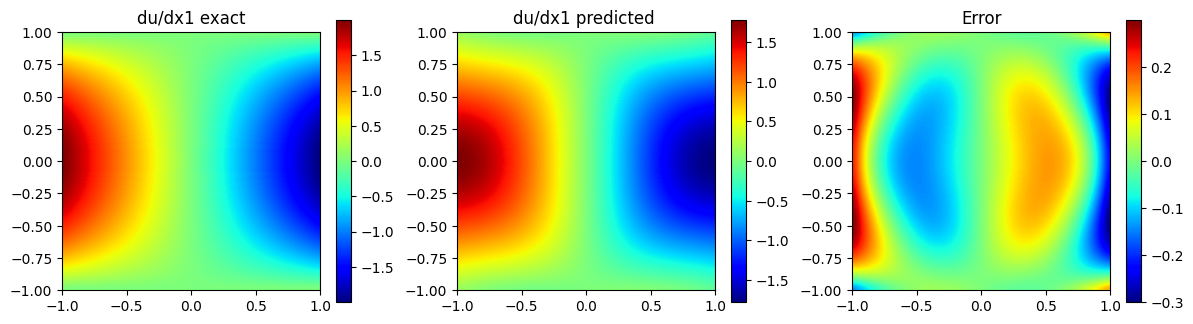

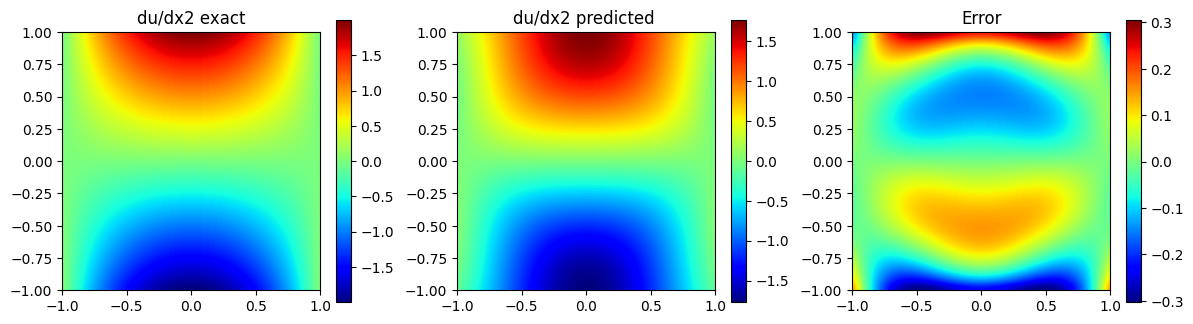

In [11]:
model.plot_metrics(49, save=False, show_points=False)

Gradient computation: dim ok


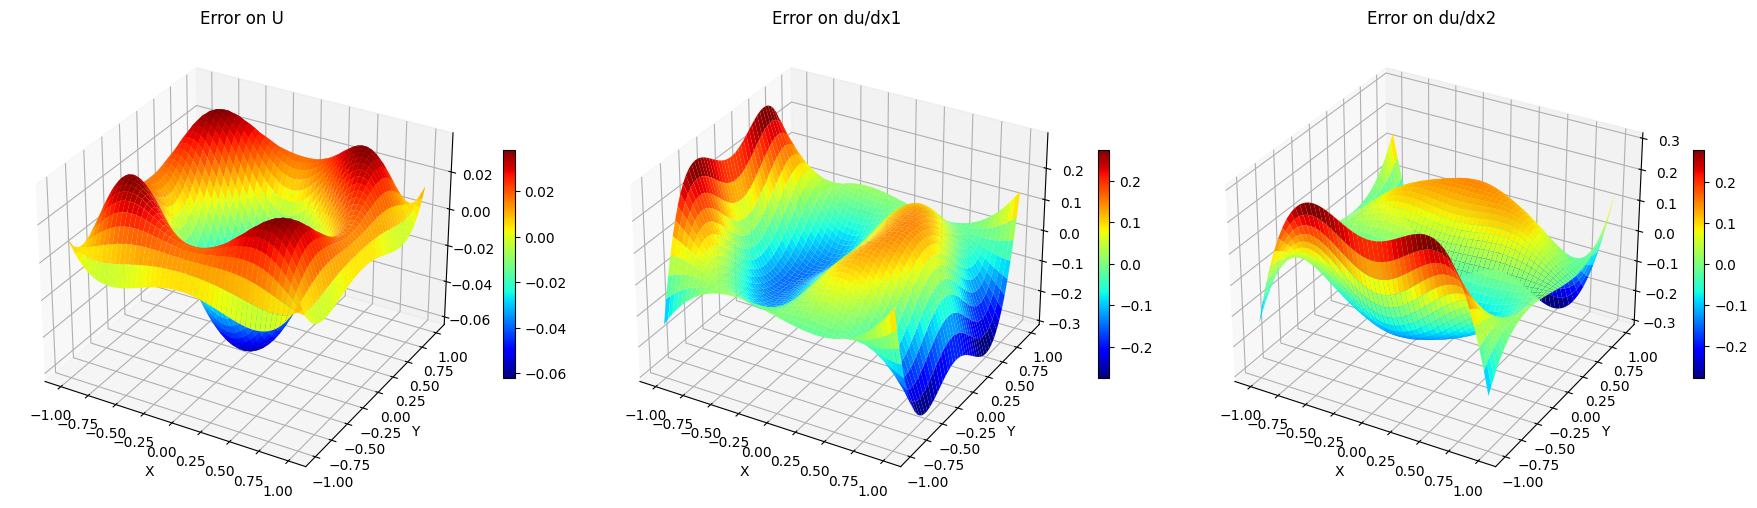

In [12]:
model.plot_metrics3d(49, save=False)

In [ ]:
import plotly.graph_objects as go
from plotly.offline import plot

evaluation_grid_size = 49
mesh_coordinates = (RectangleMesh(Point(-1, -1), Point(1, 1), evaluation_grid_size, evaluation_grid_size)).coordinates()
evaluation_domain_points = torch.FloatTensor(mesh_coordinates).to(device)
evaluation_domain_points.requires_grad = True

model_test = model.model
model_test.eval()

u_pred = model_test(evaluation_domain_points)
u_exact = (model.u(evaluation_domain_points.cpu()).unsqueeze(1)).to(device)

X = mesh_coordinates[:, 0].reshape(evaluation_grid_size+1, evaluation_grid_size+1)
Y = mesh_coordinates[:, 1].reshape(evaluation_grid_size+1, evaluation_grid_size+1)

u_pred_reshaped = plots.reshape_tensor_to_cpu(u_pred, evaluation_grid_size)
u_exact_reshaped = plots.reshape_tensor_to_cpu(u_exact, evaluation_grid_size)

du_pred_x1, du_pred_x2 = plots.partial_derivative_2D(u=u_pred,x=evaluation_domain_points)
du_exact_x1, du_exact_x2 = model.du_x1_exact(evaluation_domain_points), model.du_x2_exact(evaluation_domain_points)
du_pred_x1_reshaped, du_pred_x2_reshaped = plots.reshape_tensor_to_cpu(du_pred_x1, evaluation_grid_size), plots.reshape_tensor_to_cpu(du_pred_x2, evaluation_grid_size)
du_exact_x1_reshaped, du_exact_x2_reshaped = plots.reshape_tensor_to_cpu(du_exact_x1, evaluation_grid_size), plots.reshape_tensor_to_cpu(du_exact_x2, evaluation_grid_size)

ZU = u_exact_reshaped - u_pred_reshaped
ZDU1 = du_exact_x1_reshaped - du_pred_x1_reshaped
ZDU2 = du_exact_x2_reshaped - du_pred_x2_reshaped

fig = go.Figure(data=[go.Surface(z=ZU, x=X, y=Y, colorscale='jet', showscale=True)])

# Configuration interactive
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='u_pred',
))

fig.show()

<class 'numpy.ndarray'>
Gradient computation: dim ok


Gradient computation: dim ok
Mean absolute error: 0.047553900629282
l2_relative_error: 0.10409308989138402, l2_u_true: 26.133329391479492, l2_u_pred: 25.531145095825195
h1_relative_error: 0.15686810163248097, h1_u_true: 65.64767456054688, h1_u_pred: 62.72698211669922


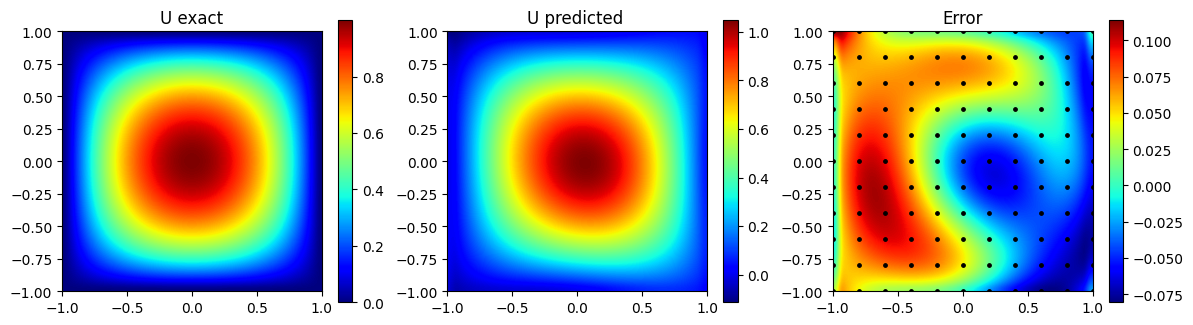

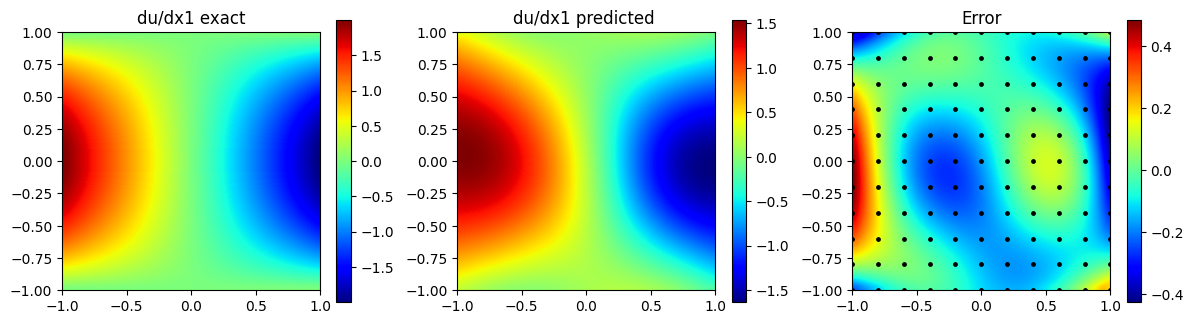

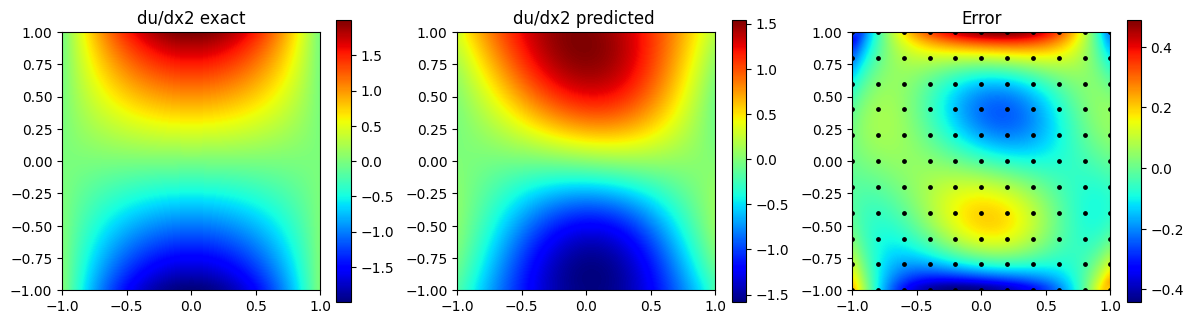

In [14]:
config_type = 2
model_name = 'cnn_fc20_iter30k_beta4000_gr10'
init_grid = int(model_name.split('_')[-1][2:])
model_type = model_name.split('_')[0]
hidden_size = int(model_name.split('_')[1][2:])

to_watch = Circle(hidden_size=hidden_size, nn=model_type, config=config_type, init_grid=init_grid)
to_watch.model.load_state_dict(torch.load(f'./Models/ex1_config{config_type}/{model_name}.pth', weights_only=True))
to_watch.plot_metrics(49, save=False)